# Exploratory Data Analysis - Sales Data Warehouse

## Objective
Analyze the cleaned and transformed sales data to extract business insights and validate the ETL pipeline quality.

## Dataset Overview
- **Source**: PySpark ETL pipeline from raw data lake
- **Schema**: Star schema (fact_sales, dim_customer, dim_product)
- **Period**: Simulated sales transactions
- **Records**: ~45K sales after data quality cleaning

## Analysis Goals
1. Validate data quality and completeness
2. Understand sales distribution patterns
3. Identify top-performing products and categories
4. Analyze customer segments
5. Evaluate discount effectiveness
6. Generate actionable business insights

## 1. Setup and Data Loading

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Load processed data from PySpark output
# PySpark writes to directories with part files, so we use glob to read all parts

# Load dimension tables
customer_files = glob.glob('../data/processed/dim_customer/part-*.csv')
product_files = glob.glob('../data/processed/dim_product/part-*.csv')
sales_files = glob.glob('../data/processed/fact_sales/part-*.csv')

dim_customer = pd.concat([pd.read_csv(f) for f in customer_files], ignore_index=True)
dim_product = pd.concat([pd.read_csv(f) for f in product_files], ignore_index=True)
fact_sales = pd.concat([pd.read_csv(f) for f in sales_files], ignore_index=True)

# Convert date columns
dim_customer['registration_date'] = pd.to_datetime(dim_customer['registration_date'])
fact_sales['sale_date'] = pd.to_datetime(fact_sales['sale_date'])

print(f"✓ Loaded {len(dim_customer):,} customers")
print(f"✓ Loaded {len(dim_product):,} products")
print(f"✓ Loaded {len(fact_sales):,} sales transactions")

✓ Loaded 963 customers
✓ Loaded 148 products
✓ Loaded 45,179 sales transactions


## 2. Data Quality Overview

In [4]:
# Check data structure and missing values
print("="*60)
print("FACT_SALES TABLE")
print("="*60)
print(f"Shape: {fact_sales.shape}")
print(f"\nColumns: {list(fact_sales.columns)}")
print(f"\nData Types:\n{fact_sales.dtypes}")
print(f"\nMissing Values:\n{fact_sales.isnull().sum()}")
print(f"\nMemory Usage: {fact_sales.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

FACT_SALES TABLE
Shape: (45179, 12)

Columns: ['sale_id', 'customer_id', 'product_id', 'sale_date', 'quantity', 'unit_price', 'discount_percent', 'amount_before_discount', 'discount_amount', 'total_amount', 'payment_method', 'status']

Data Types:
sale_id                            int64
customer_id                        int64
product_id                         int64
sale_date                 datetime64[ns]
quantity                           int64
unit_price                       float64
discount_percent                   int64
amount_before_discount           float64
discount_amount                  float64
total_amount                     float64
payment_method                    object
status                            object
dtype: object

Missing Values:
sale_id                   0
customer_id               0
product_id                0
sale_date                 0
quantity                  0
unit_price                0
discount_percent          0
amount_before_discount    0
disco

In [5]:
print("="*60)
print("DIM_CUSTOMER TABLE")
print("="*60)
print(f"Shape: {dim_customer.shape}")
print(f"\nColumns: {list(dim_customer.columns)}")
print(f"\nMissing Values:\n{dim_customer.isnull().sum()}")
print(f"\nUnique customers: {dim_customer['customer_id'].nunique()}")
print(f"Duplicate emails: {dim_customer['email'].duplicated().sum()}")

DIM_CUSTOMER TABLE
Shape: (963, 7)

Columns: ['customer_id', 'name', 'email', 'country', 'registration_date', 'segment', 'city']

Missing Values:
customer_id          0
name                 0
email                0
country              0
registration_date    0
segment              0
city                 0
dtype: int64

Unique customers: 963
Duplicate emails: 0


In [6]:
print("="*60)
print("DIM_PRODUCT TABLE")
print("="*60)
print(f"Shape: {dim_product.shape}")
print(f"\nColumns: {list(dim_product.columns)}")
print(f"\nMissing Values:\n{dim_product.isnull().sum()}")
print(f"\nUnique products: {dim_product['product_id'].nunique()}")
print(f"Categories: {dim_product['category'].nunique()}")
print(f"\nCategory distribution:\n{dim_product['category'].value_counts()}")

DIM_PRODUCT TABLE
Shape: (148, 6)

Columns: ['product_id', 'product_name', 'category', 'unit_price', 'supplier', 'rating']

Missing Values:
product_id      0
product_name    0
category        0
unit_price      0
supplier        0
rating          0
dtype: int64

Unique products: 148
Categories: 6

Category distribution:
category
Beauty         33
Home           27
Electronics    25
Clothing       24
Books          20
Sports         19
Name: count, dtype: int64


## 3. Statistical Summaries

In [7]:
# Sales metrics summary
print("="*60)
print("SALES METRICS SUMMARY")
print("="*60)

sales_summary = fact_sales[['quantity', 'unit_price', 'discount_percent', 
                            'amount_before_discount', 'discount_amount', 'total_amount']].describe()
print(sales_summary.round(2))

print(f"\nTotal Revenue: ${fact_sales['total_amount'].sum():,.2f}")
print(f"Average Order Value: ${fact_sales['total_amount'].mean():,.2f}")
print(f"Total Discount Given: ${fact_sales['discount_amount'].sum():,.2f}")
print(f"Average Discount: {fact_sales['discount_percent'].mean():.2f}%")

SALES METRICS SUMMARY
       quantity  unit_price  discount_percent  amount_before_discount  \
count  45179.00    45179.00          45179.00                45179.00   
mean       1.75      391.80              3.50                  682.41   
std        0.94      479.65              8.07                 1015.31   
min        1.00       13.30              0.00                   13.30   
25%        1.00       73.79              0.00                  106.76   
50%        1.00      172.57              0.00                  281.81   
75%        2.00      557.78              5.00                  764.50   
max        5.00     1936.44            100.00                 9682.20   

       discount_amount  total_amount  
count         45179.00      45179.00  
mean             23.53        658.87  
std              92.09        985.13  
min               0.00          0.00  
25%               0.00        101.54  
50%               0.00        270.76  
75%              13.54        745.91  
max     

In [8]:
# Customer segments distribution
print("="*60)
print("CUSTOMER SEGMENTS")
print("="*60)

segment_counts = dim_customer['segment'].value_counts()
print(segment_counts)
print(f"\nPercentage distribution:")
print((segment_counts / len(dim_customer) * 100).round(2))

CUSTOMER SEGMENTS
segment
Standard    479
Basic       276
Premium     208
Name: count, dtype: int64

Percentage distribution:
segment
Standard    49.74
Basic       28.66
Premium     21.60
Name: count, dtype: float64


In [9]:
# Top countries
print("="*60)
print("TOP 10 COUNTRIES BY CUSTOMER COUNT")
print("="*60)
print(dim_customer['country'].value_counts().head(10))

TOP 10 COUNTRIES BY CUSTOMER COUNT
country
Peru         136
Argentina    133
Spain        129
USA          127
Brazil       122
Colombia     113
Mexico       103
Chile        100
Name: count, dtype: int64


## 4. Sales Analysis by Product Category

In [10]:
# Merge sales with product data for category analysis
sales_with_products = fact_sales.merge(
    dim_product[['product_id', 'category', 'product_name', 'rating']], 
    on='product_id', 
    how='left'
)

# Sales by category
category_sales = sales_with_products.groupby('category').agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'sale_id': 'count'
}).round(2)

category_sales.columns = ['Total Revenue', 'Units Sold', 'Transactions']
category_sales = category_sales.sort_values('Total Revenue', ascending=False)

print("="*60)
print("SALES BY CATEGORY")
print("="*60)
print(category_sales)

SALES BY CATEGORY
             Total Revenue  Units Sold  Transactions
category                                            
Electronics    15959832.46       13494          7742
Home            7297559.94       14286          8217
Sports          2722702.90       10032          5781
Beauty          1808387.81       17426          9976
Clothing        1671888.57       12814          7289
Books            306937.39       10798          6174


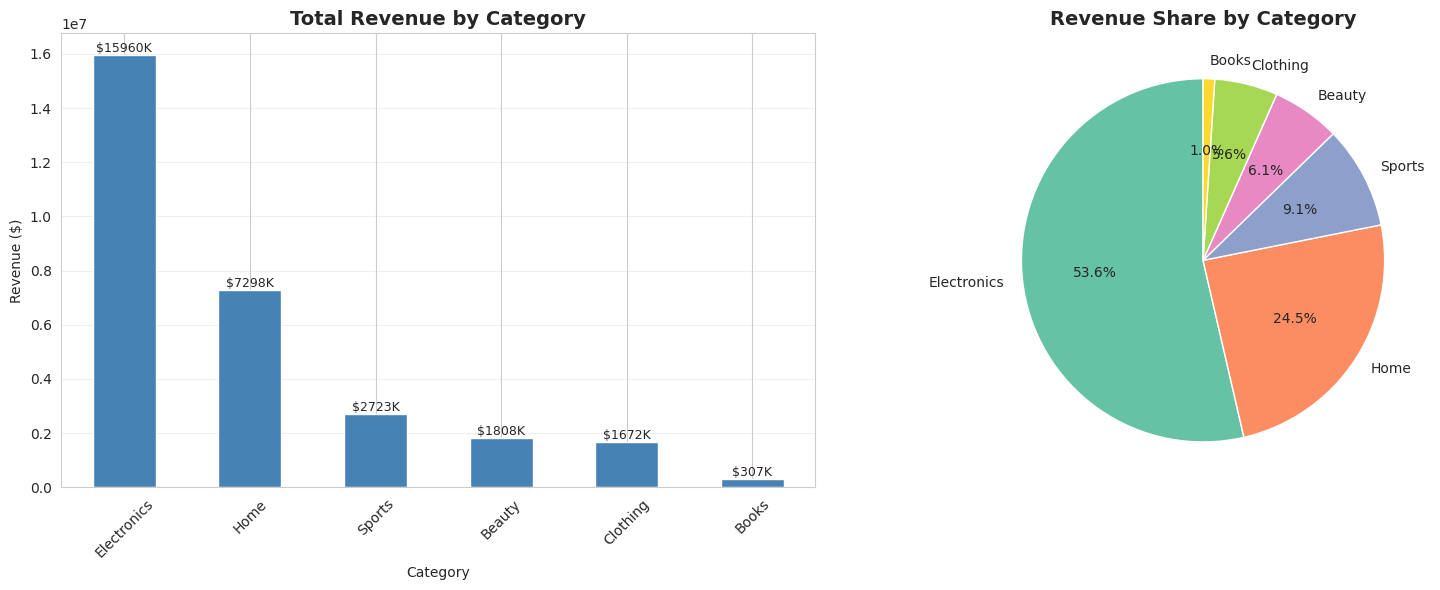

In [11]:
# Visualization: Revenue by Category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
category_sales['Total Revenue'].plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Total Revenue by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(category_sales['Total Revenue']):
    axes[0].text(i, v, f'${v/1000:.0f}K', ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(category_sales['Total Revenue'], labels=category_sales.index, 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
axes[1].set_title('Revenue Share by Category', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Top Products Analysis

In [12]:
# Top 10 products by revenue
top_products = sales_with_products.groupby(['product_id', 'product_name', 'category']).agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'sale_id': 'count'
}).round(2)

top_products.columns = ['Revenue', 'Units Sold', 'Transactions']
top_products = top_products.sort_values('Revenue', ascending=False).head(10)

print("="*60)
print("TOP 10 PRODUCTS BY REVENUE")
print("="*60)
print(top_products)

TOP 10 PRODUCTS BY REVENUE
                                                Revenue  Units Sold  \
product_id product_name         category                              
243        Puma Camera          Electronics  1032025.70         552   
236        Adidas Tablet        Electronics  1015997.93         560   
249        Microsoft Camera     Electronics   985726.97         541   
197        Puma Monitor         Electronics   974451.48         541   
216        Microsoft Headphones Electronics   950710.41         578   
193        Nike Headphones      Electronics   949575.51         525   
187        Bose Smartphone      Electronics   893702.43         520   
149        HP Speaker           Electronics   824991.00         538   
218        Bose Speaker         Electronics   799902.90         470   
181        Reebok Laptop        Electronics   717087.29         471   

                                             Transactions  
product_id product_name         category                   


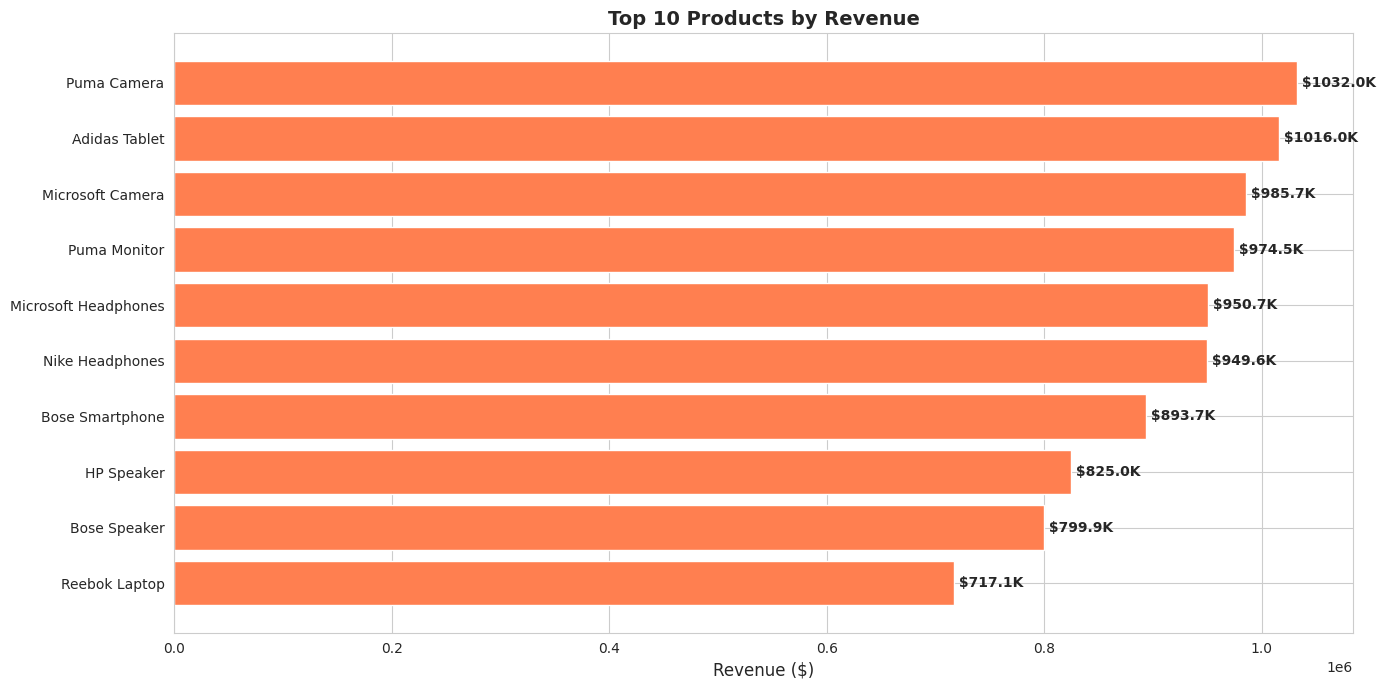

In [13]:
# Visualization: Top 10 products
fig, ax = plt.subplots(figsize=(14, 7))

top_products_plot = top_products.reset_index()
bars = ax.barh(range(len(top_products_plot)), top_products_plot['Revenue'], color='coral')

ax.set_yticks(range(len(top_products_plot)))
ax.set_yticklabels([f"{row['product_name'][:30]}..." if len(row['product_name']) > 30 
                     else row['product_name'] for _, row in top_products_plot.iterrows()])
ax.set_xlabel('Revenue ($)', fontsize=12)
ax.set_title('Top 10 Products by Revenue', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_products_plot.iterrows()):
    ax.text(row['Revenue'], i, f" ${row['Revenue']/1000:.1f}K", 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Customer Segment Analysis

In [14]:
# Merge sales with customer data
sales_with_customers = fact_sales.merge(
    dim_customer[['customer_id', 'segment', 'country']], 
    on='customer_id', 
    how='left'
)

# Segment performance
segment_performance = sales_with_customers.groupby('segment').agg({
    'total_amount': ['sum', 'mean'],
    'sale_id': 'count',
    'customer_id': 'nunique'
}).round(2)

segment_performance.columns = ['Total Revenue', 'Avg Order Value', 'Transactions', 'Unique Customers']
segment_performance['Revenue per Customer'] = (segment_performance['Total Revenue'] / 
                                               segment_performance['Unique Customers']).round(2)
segment_performance = segment_performance.sort_values('Total Revenue', ascending=False)

print("="*60)
print("CUSTOMER SEGMENT PERFORMANCE")
print("="*60)
print(segment_performance)

CUSTOMER SEGMENT PERFORMANCE
          Total Revenue  Avg Order Value  Transactions  Unique Customers  \
segment                                                                    
Standard    14550088.71           645.32         22547               479   
Premium      8768729.18           900.19          9741               208   
Basic        6448491.17           500.23         12891               276   

          Revenue per Customer  
segment                         
Standard              30375.97  
Premium               42157.35  
Basic                 23364.10  


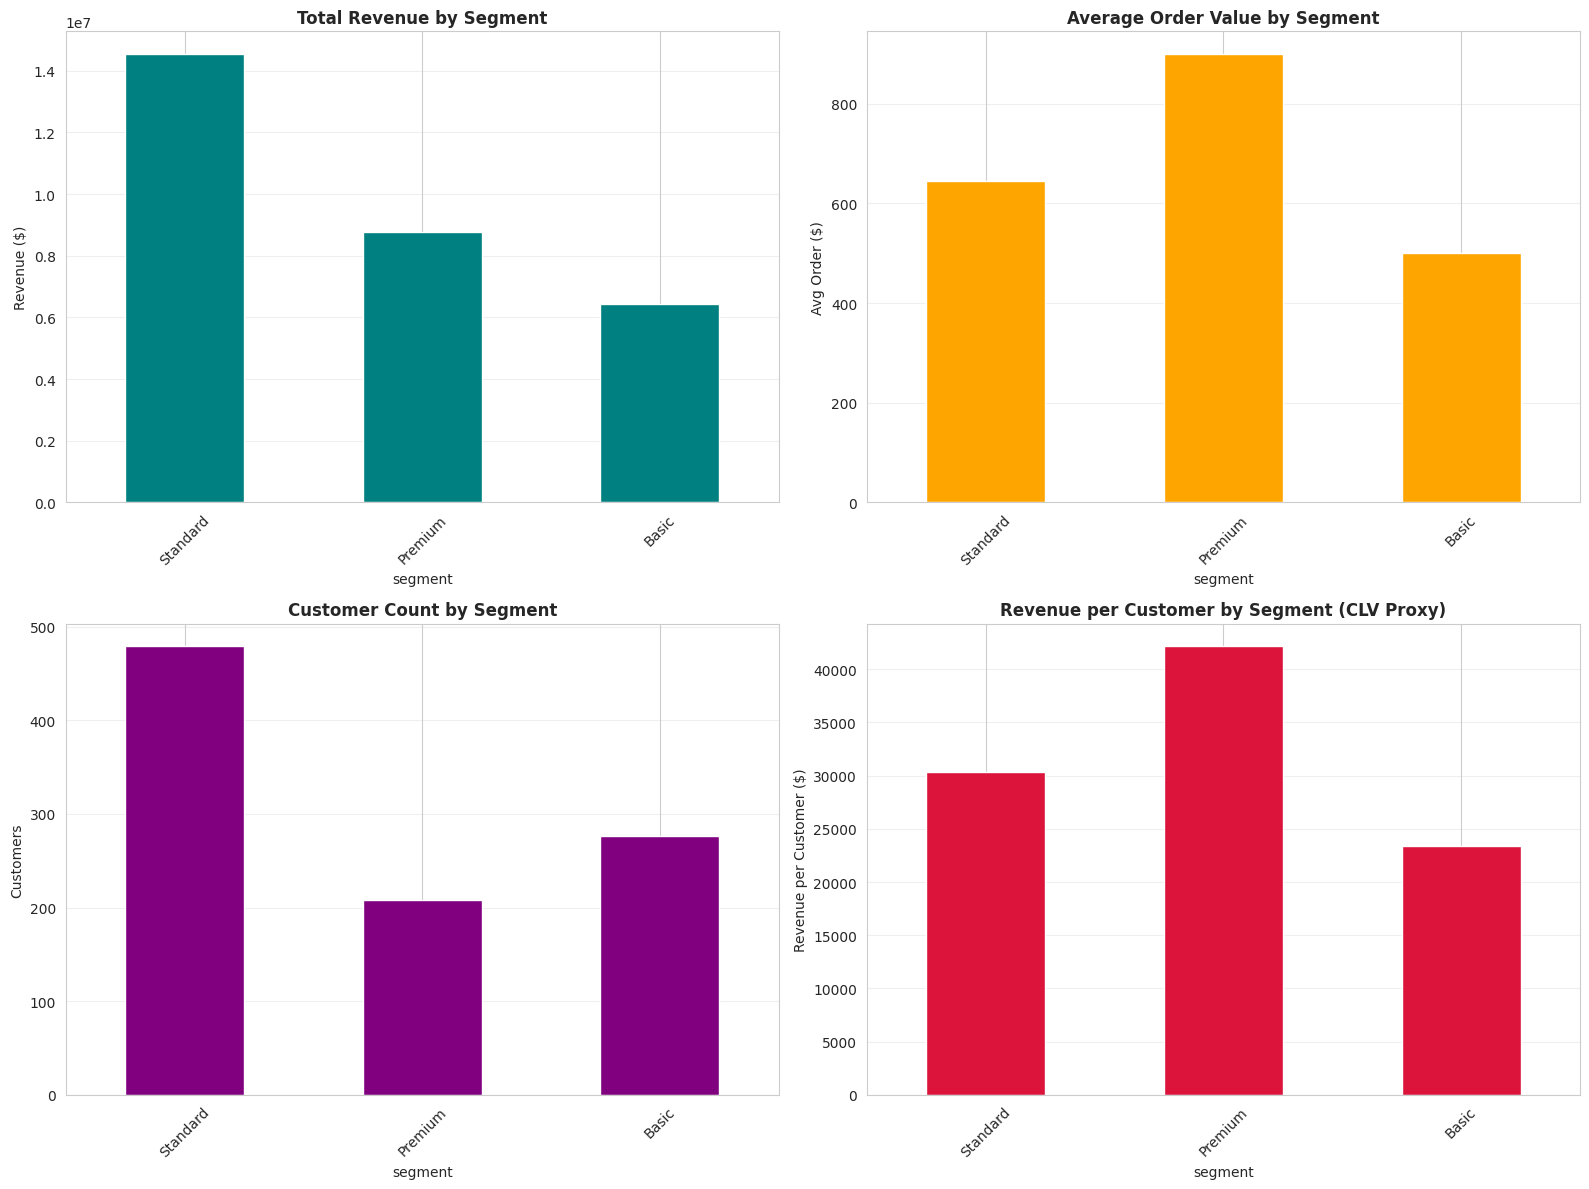

In [15]:
# Visualization: Segment comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Revenue by segment
segment_performance['Total Revenue'].plot(kind='bar', ax=axes[0, 0], color='teal')
axes[0, 0].set_title('Total Revenue by Segment', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Average order value
segment_performance['Avg Order Value'].plot(kind='bar', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Average Order Value by Segment', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Avg Order ($)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# Customer count
segment_performance['Unique Customers'].plot(kind='bar', ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Customer Count by Segment', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Customers')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Revenue per customer (CLV proxy)
segment_performance['Revenue per Customer'].plot(kind='bar', ax=axes[1, 1], color='crimson')
axes[1, 1].set_title('Revenue per Customer by Segment (CLV Proxy)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Revenue per Customer ($)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Time Series Analysis

In [16]:
# Sales trends over time
fact_sales['year_month'] = fact_sales['sale_date'].dt.to_period('M')

monthly_sales = fact_sales.groupby('year_month').agg({
    'total_amount': 'sum',
    'sale_id': 'count',
    'quantity': 'sum'
}).reset_index()

monthly_sales['year_month'] = monthly_sales['year_month'].dt.to_timestamp()
monthly_sales.columns = ['Month', 'Revenue', 'Transactions', 'Units Sold']

print("="*60)
print("MONTHLY SALES TRENDS")
print("="*60)
print(monthly_sales.head(10))

MONTHLY SALES TRENDS
       Month       Revenue  Transactions  Units Sold
0 2023-01-01  1.502924e+06          2165        3734
1 2023-02-01  1.336254e+06          1996        3533
2 2023-03-01  1.439587e+06          2155        3735
3 2023-04-01  1.324625e+06          2062        3568
4 2023-05-01  1.429066e+06          2173        3758
5 2023-06-01  1.351562e+06          2094        3655
6 2023-07-01  1.406433e+06          2099        3673
7 2023-08-01  1.397894e+06          2134        3691
8 2023-09-01  1.364381e+06          2072        3713
9 2023-10-01  1.406249e+06          2158        3742


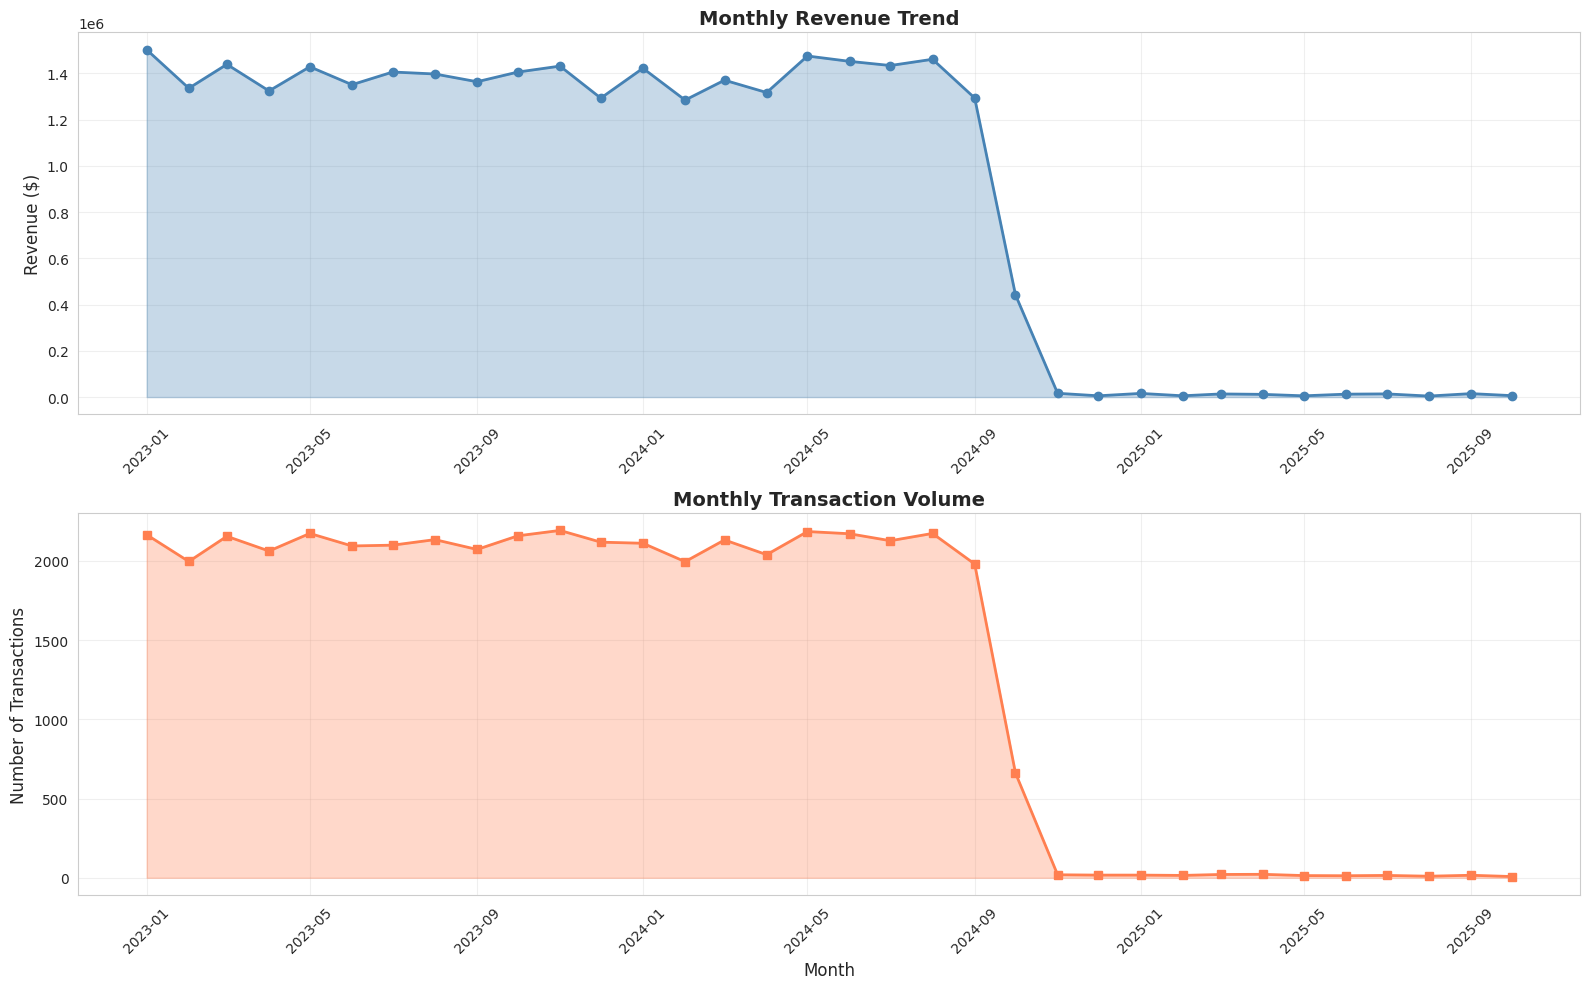

In [17]:
# Visualization: Time series
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Revenue over time
axes[0].plot(monthly_sales['Month'], monthly_sales['Revenue'], 
             marker='o', linewidth=2, color='steelblue', markersize=6)
axes[0].fill_between(monthly_sales['Month'], monthly_sales['Revenue'], alpha=0.3, color='steelblue')
axes[0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Transactions over time
axes[1].plot(monthly_sales['Month'], monthly_sales['Transactions'], 
             marker='s', linewidth=2, color='coral', markersize=6)
axes[1].fill_between(monthly_sales['Month'], monthly_sales['Transactions'], alpha=0.3, color='coral')
axes[1].set_title('Monthly Transaction Volume', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Transactions', fontsize=12)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Discount Analysis

In [18]:
# Discount effectiveness analysis
# Create discount bins
fact_sales['discount_bin'] = pd.cut(
    fact_sales['discount_percent'], 
    bins=[-1, 0, 10, 20, 30, 100],
    labels=['No Discount', '1-10%', '11-20%', '21-30%', '30%+']
)

discount_analysis = fact_sales.groupby('discount_bin').agg({
    'total_amount': ['sum', 'mean'],
    'quantity': 'sum',
    'sale_id': 'count'
}).round(2)

discount_analysis.columns = ['Total Revenue', 'Avg Order Value', 'Total Units', 'Transactions']

print("="*60)
print("DISCOUNT EFFECTIVENESS ANALYSIS")
print("="*60)
print(discount_analysis)
print(f"\nTotal Discount Amount: ${fact_sales['discount_amount'].sum():,.2f}")
print(f"Discount as % of Revenue: {(fact_sales['discount_amount'].sum() / fact_sales['amount_before_discount'].sum() * 100):.2f}%")

DISCOUNT EFFECTIVENESS ANALYSIS
              Total Revenue  Avg Order Value  Total Units  Transactions
discount_bin                                                           
No Discount     17589268.60           679.70        45189         25878
1-10%           11452214.13           644.25        31049         17776
11-20%            725826.33           561.35         2225          1293
21-30%                 0.00              NaN            0             0
30%+                   0.00             0.00          387           232

Total Discount Amount: $1,063,186.13
Discount as % of Revenue: 3.45%


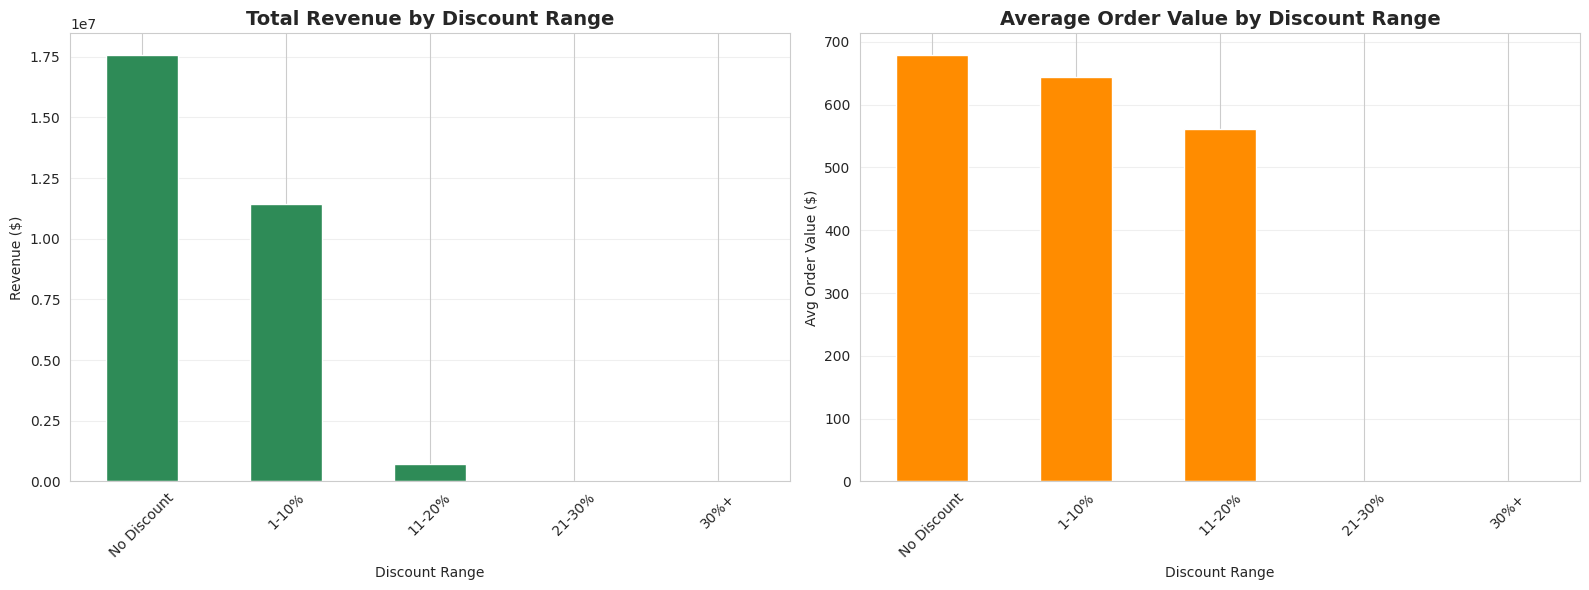

In [19]:
# Visualization: Discount impact
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Revenue by discount bin
discount_analysis['Total Revenue'].plot(kind='bar', ax=axes[0], color='seagreen')
axes[0].set_title('Total Revenue by Discount Range', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue ($)')
axes[0].set_xlabel('Discount Range')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Average order value by discount
discount_analysis['Avg Order Value'].plot(kind='bar', ax=axes[1], color='darkorange')
axes[1].set_title('Average Order Value by Discount Range', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Avg Order Value ($)')
axes[1].set_xlabel('Discount Range')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

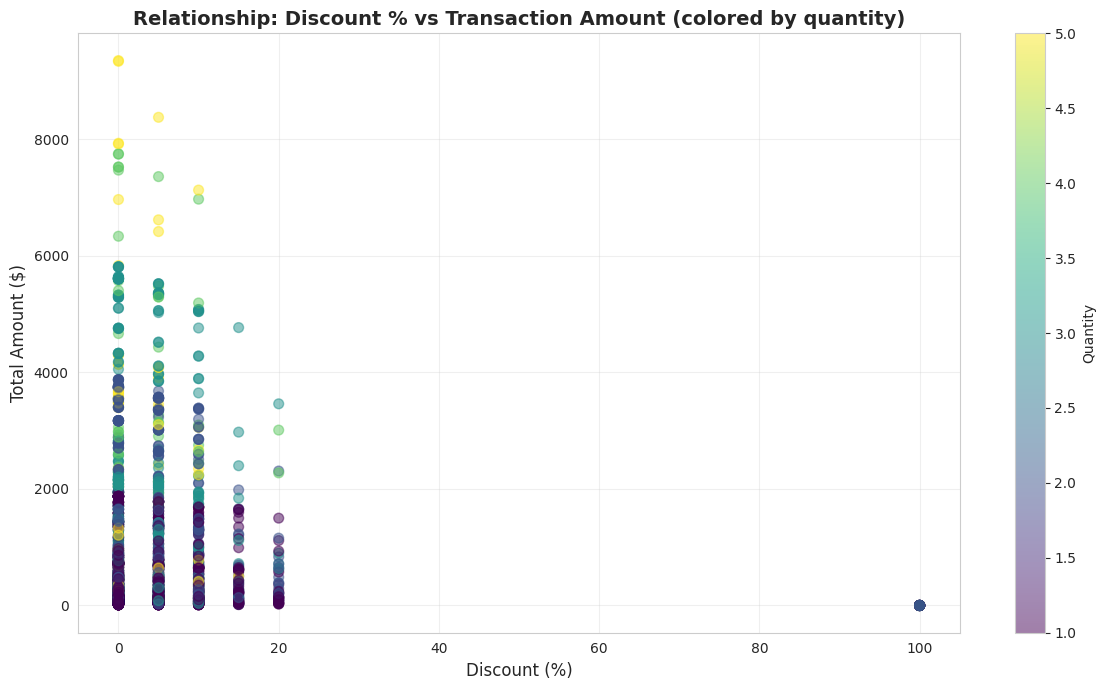

In [20]:
# Scatter plot: Discount vs Revenue
# Sample data for better visualization
sample_sales = fact_sales.sample(min(5000, len(fact_sales)), random_state=42)

plt.figure(figsize=(12, 7))
scatter = plt.scatter(sample_sales['discount_percent'], 
                     sample_sales['total_amount'],
                     alpha=0.5, 
                     c=sample_sales['quantity'], 
                     cmap='viridis',
                     s=50)

plt.colorbar(scatter, label='Quantity')
plt.xlabel('Discount (%)', fontsize=12)
plt.ylabel('Total Amount ($)', fontsize=12)
plt.title('Relationship: Discount % vs Transaction Amount (colored by quantity)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Geographic Analysis

In [21]:
# Top countries by revenue
country_sales = sales_with_customers.groupby('country').agg({
    'total_amount': 'sum',
    'sale_id': 'count',
    'customer_id': 'nunique'
}).round(2)

country_sales.columns = ['Revenue', 'Transactions', 'Customers']
country_sales['Revenue per Customer'] = (country_sales['Revenue'] / country_sales['Customers']).round(2)
country_sales = country_sales.sort_values('Revenue', ascending=False).head(15)

print("="*60)
print("TOP 15 COUNTRIES BY REVENUE")
print("="*60)
print(country_sales)

TOP 15 COUNTRIES BY REVENUE
              Revenue  Transactions  Customers  Revenue per Customer
country                                                             
Argentina  4246912.28          6267        133              31931.67
Peru       4031390.38          6472        136              29642.58
Spain      3926964.09          5919        129              30441.58
USA        3898232.30          5902        127              30694.74
Brazil     3655571.02          5669        122              29963.70
Colombia   3478442.04          5375        113              30782.67
Chile      3384137.15          4794        100              33841.37
Mexico     3145659.80          4781        103              30540.39


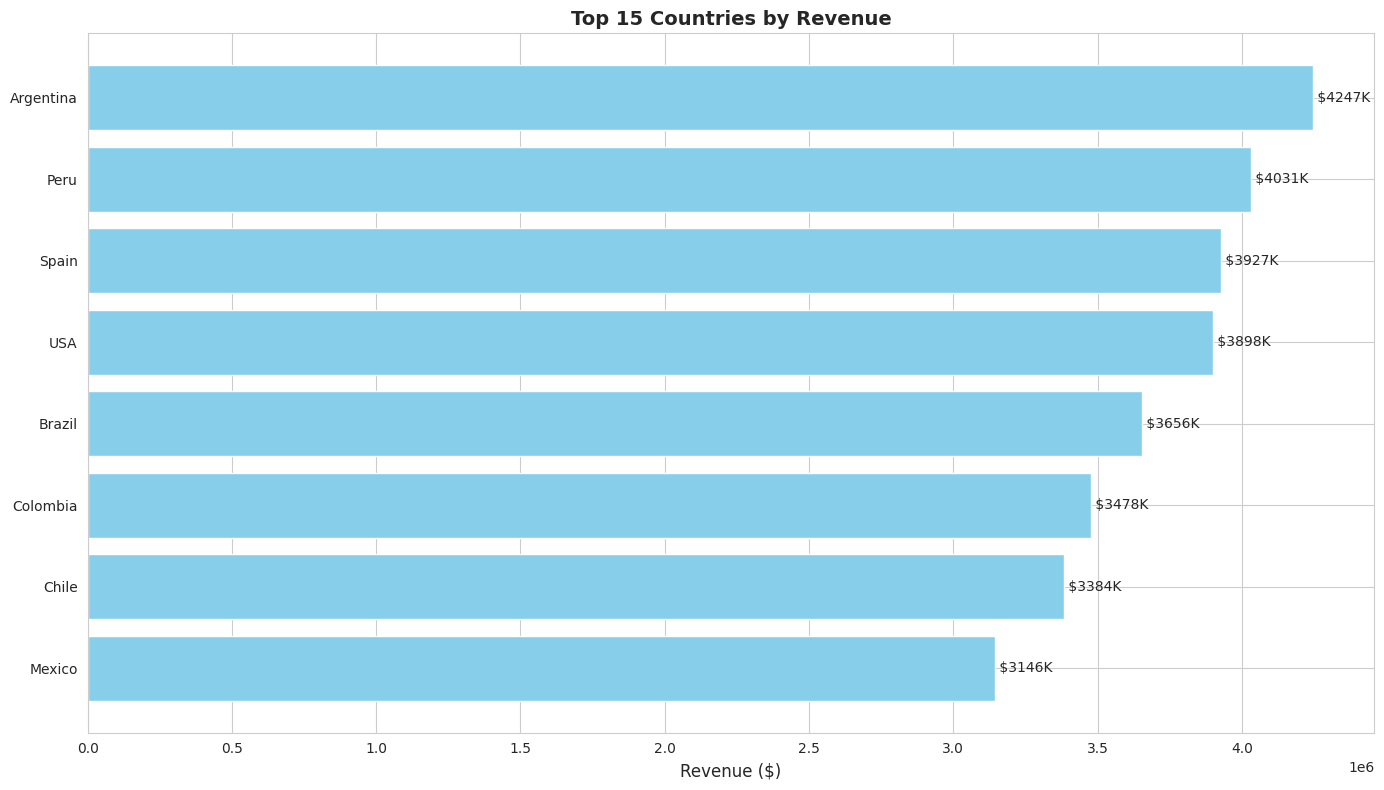

In [22]:
# Visualization: Top countries
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(range(len(country_sales)), country_sales['Revenue'], color='skyblue')
ax.set_yticks(range(len(country_sales)))
ax.set_yticklabels(country_sales.index)
ax.set_xlabel('Revenue ($)', fontsize=12)
ax.set_title('Top 15 Countries by Revenue', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, v in enumerate(country_sales['Revenue']):
    ax.text(v, i, f" ${v/1000:.0f}K", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 10. Correlation Analysis

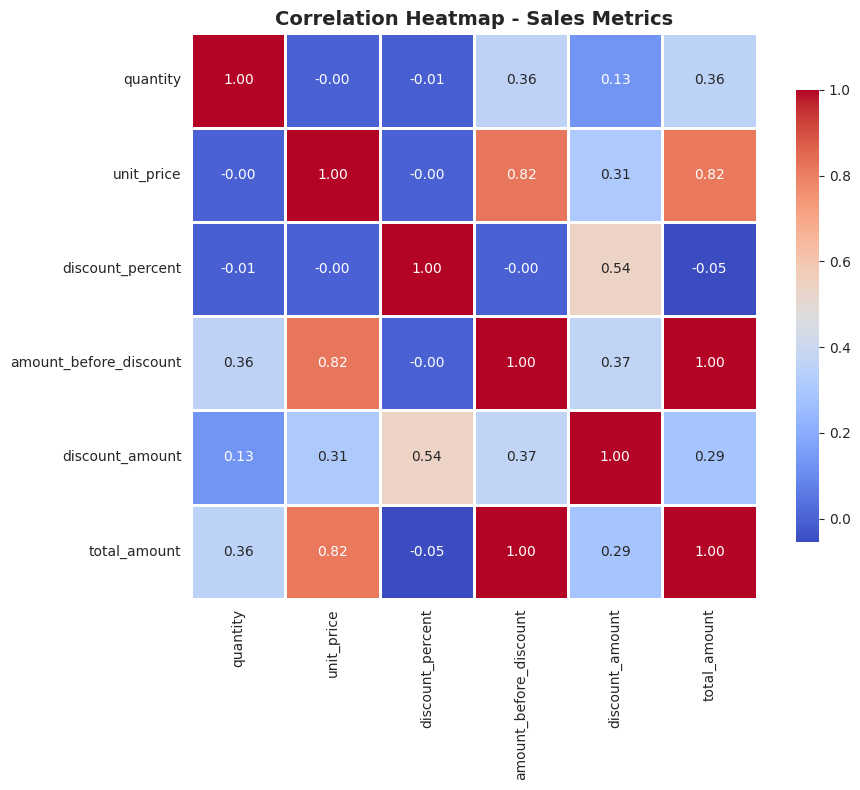


Key Correlations:
                        quantity  unit_price  discount_percent  \
quantity                1.000000   -0.003101         -0.006115   
unit_price             -0.003101    1.000000         -0.001465   
discount_percent       -0.006115   -0.001465          1.000000   
amount_before_discount  0.357276    0.821876         -0.004102   
discount_amount         0.129801    0.308067          0.540629   
total_amount            0.356088    0.818258         -0.054765   

                        amount_before_discount  discount_amount  total_amount  
quantity                              0.357276         0.129801      0.356088  
unit_price                            0.821876         0.308067      0.818258  
discount_percent                     -0.004102         0.540629     -0.054765  
amount_before_discount                1.000000         0.368208      0.996216  
discount_amount                       0.368208         1.000000      0.286011  
total_amount                          

In [23]:
# Correlation matrix for numerical features
correlation_data = fact_sales[['quantity', 'unit_price', 'discount_percent', 
                               'amount_before_discount', 'discount_amount', 'total_amount']]

correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Sales Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Correlations:")
print("="*60)
print(correlation_matrix)

## 11. Payment Method Analysis

In [24]:
# Payment method distribution
payment_analysis = fact_sales.groupby('payment_method').agg({
    'total_amount': ['sum', 'mean'],
    'sale_id': 'count'
}).round(2)

payment_analysis.columns = ['Total Revenue', 'Avg Transaction', 'Count']
payment_analysis = payment_analysis.sort_values('Total Revenue', ascending=False)

print("="*60)
print("PAYMENT METHOD ANALYSIS")
print("="*60)
print(payment_analysis)

PAYMENT METHOD ANALYSIS
                Total Revenue  Avg Transaction  Count
payment_method                                       
Credit Card       14686122.19           650.92  22562
Debit Card         7579887.08           668.42  11340
PayPal             4457619.41           651.51   6842
Cash               3043680.38           686.29   4435


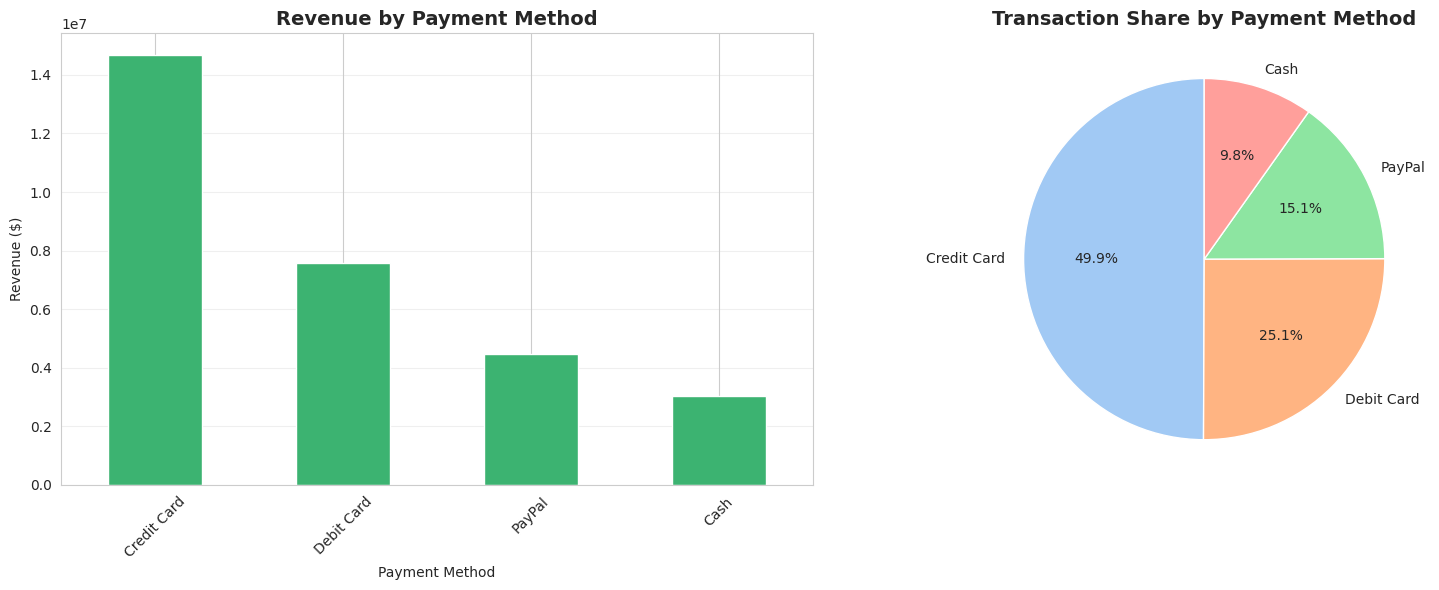

In [25]:
# Visualization: Payment methods
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Revenue by payment method
payment_analysis['Total Revenue'].plot(kind='bar', ax=axes[0], color='mediumseagreen')
axes[0].set_title('Revenue by Payment Method', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue ($)')
axes[0].set_xlabel('Payment Method')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Transaction count pie chart
axes[1].pie(payment_analysis['Count'], labels=payment_analysis.index, 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
axes[1].set_title('Transaction Share by Payment Method', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 12. Product Rating Analysis

In [26]:
# Sales performance by product rating
sales_with_products['rating_category'] = pd.cut(
    sales_with_products['rating'],
    bins=[0, 3, 4, 5],
    labels=['Low (0-3)', 'Medium (3-4)', 'High (4-5)']
)

rating_performance = sales_with_products.groupby('rating_category').agg({
    'total_amount': ['sum', 'mean'],
    'quantity': 'sum',
    'sale_id': 'count'
}).round(2)

rating_performance.columns = ['Total Revenue', 'Avg Order', 'Units Sold', 'Transactions']

print("="*60)
print("SALES BY PRODUCT RATING")
print("="*60)
print(rating_performance)

SALES BY PRODUCT RATING
                 Total Revenue  Avg Order  Units Sold  Transactions
rating_category                                                    
Low (0-3)                 0.00        NaN           0             0
Medium (3-4)       10626842.50     645.73       28699         16457
High (4-5)         19140466.56     666.40       50151         28722


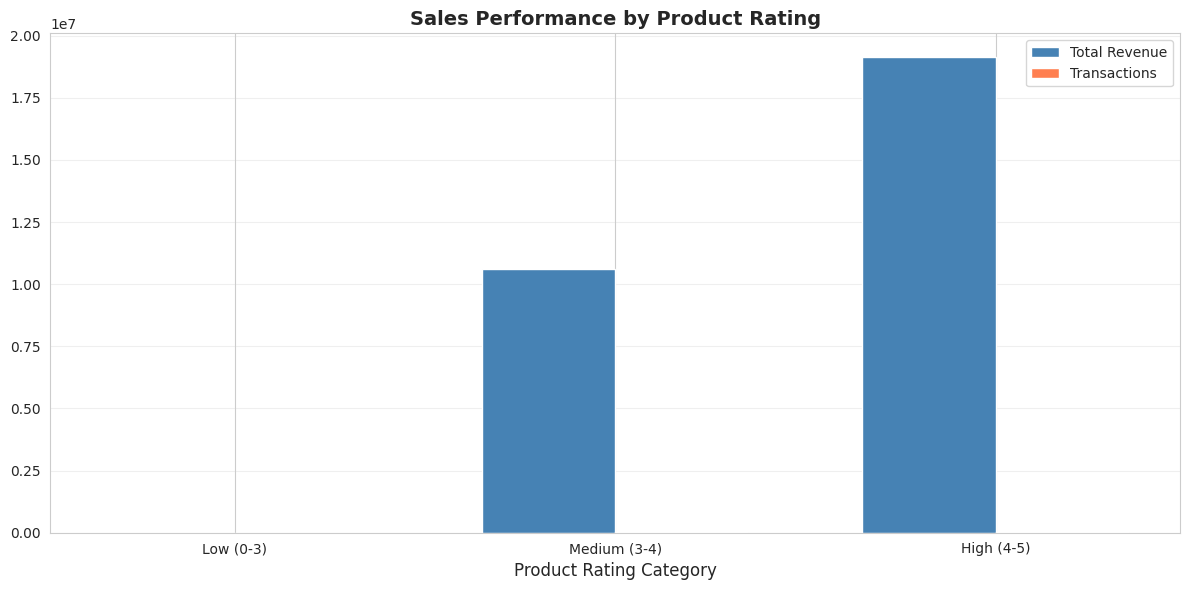

In [27]:
# Visualization: Rating impact
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(rating_performance))
width = 0.35

bars1 = ax.bar(x - width/2, rating_performance['Total Revenue'], width, 
               label='Total Revenue', color='steelblue')
bars2 = ax.bar(x + width/2, rating_performance['Transactions'], width, 
               label='Transactions', color='coral')

ax.set_xlabel('Product Rating Category', fontsize=12)
ax.set_title('Sales Performance by Product Rating', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(rating_performance.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Key Business Insights

Based on the exploratory analysis, here are the key findings and recommendations:

In [28]:
# Calculate key metrics for insights
total_revenue = fact_sales['total_amount'].sum()
total_transactions = len(fact_sales)
avg_order_value = fact_sales['total_amount'].mean()
total_customers = fact_sales['customer_id'].nunique()
total_discount_given = fact_sales['discount_amount'].sum()
discount_pct_of_revenue = (total_discount_given / fact_sales['amount_before_discount'].sum()) * 100

# Top category
top_category = category_sales.index[0]
top_category_revenue = category_sales.iloc[0]['Total Revenue']
top_category_pct = (top_category_revenue / total_revenue) * 100

# Best segment
best_segment = segment_performance.index[0]
best_segment_clv = segment_performance.iloc[0]['Revenue per Customer']

# Top country
top_country = country_sales.index[0]
top_country_revenue = country_sales.iloc[0]['Revenue']

print("="*80)
print("KEY BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*80)
print()

print("📊 INSIGHT 1: Revenue Concentration")
print("-" * 80)
print(f"The '{top_category}' category dominates with ${top_category_revenue:,.2f} ({top_category_pct:.1f}% of total revenue).")
print(f"\n💡 RECOMMENDATION:")
print(f"   - Diversify product portfolio to reduce dependency on {top_category}")
print(f"   - Investigate why this category performs so well and replicate in others")
print(f"   - Consider expanding subcategories within {top_category}")
print()

print("📊 INSIGHT 2: Customer Segment Performance")
print("-" * 80)
print(f"The '{best_segment}' segment shows highest CLV at ${best_segment_clv:,.2f} per customer.")
print(f"\n💡 RECOMMENDATION:")
print(f"   - Focus acquisition and retention efforts on {best_segment} segment")
print(f"   - Create personalized marketing campaigns for this segment")
print(f"   - Analyze characteristics to find lookalike audiences")
print()

print("📊 INSIGHT 3: Discount Strategy")
print("-" * 80)
print(f"Total discounts: ${total_discount_given:,.2f} ({discount_pct_of_revenue:.2f}% of gross revenue)")
no_discount_revenue = discount_analysis.loc['No Discount', 'Total Revenue'] if 'No Discount' in discount_analysis.index else 0
discount_revenue = total_revenue - no_discount_revenue
print(f"Revenue from discounted sales: ${discount_revenue:,.2f}")
print(f"\n💡 RECOMMENDATION:")
print(f"   - Analyze if discounts drive incremental volume or just reduce margins")
print(f"   - Test A/B campaigns with varying discount levels (5%, 10%, 15%)")
print(f"   - Consider value-adds instead of pure price discounts")
print()

print("📊 INSIGHT 4: Geographic Opportunities")
print("-" * 80)
print(f"{top_country} leads with ${top_country_revenue:,.2f} in revenue.")
print(f"Top 5 countries represent {(country_sales.head(5)['Revenue'].sum() / total_revenue * 100):.1f}% of total revenue.")
print(f"\n💡 RECOMMENDATION:")
print(f"   - Strengthen presence in top-performing markets")
print(f"   - Identify underperforming countries with high customer counts for growth")
print(f"   - Localize marketing and product offerings by region")
print()

print("📊 INSIGHT 5: Data Quality Success")
print("-" * 80)
print(f"ETL pipeline successfully cleaned {total_transactions:,} transactions.")
print(f"Star schema enables efficient analytical queries.")
print(f"\n💡 RECOMMENDATION:")
print(f"   - Deploy to AWS (S3 → Glue → Redshift) for production scale")
print(f"   - Implement Great Expectations for ongoing data quality monitoring")
print(f"   - Schedule automated ETL runs with Airflow or AWS Step Functions")
print(f"   - Create QuickSight dashboards for business users")
print()

print("="*80)
print("NEXT STEPS FOR PRODUCTION")
print("="*80)
print("1. Deploy pipeline to AWS infrastructure")
print("2. Set up monitoring and alerting (CloudWatch)")
print("3. Create customer-facing dashboards (QuickSight/Tableau)")
print("4. Implement incremental loads for efficiency")
print("5. Add predictive models (churn, CLV forecasting)")
print("="*80)

KEY BUSINESS INSIGHTS & RECOMMENDATIONS

📊 INSIGHT 1: Revenue Concentration
--------------------------------------------------------------------------------
The 'Electronics' category dominates with $15,959,832.46 (53.6% of total revenue).

💡 RECOMMENDATION:
   - Diversify product portfolio to reduce dependency on Electronics
   - Investigate why this category performs so well and replicate in others
   - Consider expanding subcategories within Electronics

📊 INSIGHT 2: Customer Segment Performance
--------------------------------------------------------------------------------
The 'Standard' segment shows highest CLV at $30,375.97 per customer.

💡 RECOMMENDATION:
   - Focus acquisition and retention efforts on Standard segment
   - Create personalized marketing campaigns for this segment
   - Analyze characteristics to find lookalike audiences

📊 INSIGHT 3: Discount Strategy
--------------------------------------------------------------------------------
Total discounts: $1,063,186.13

## Summary Statistics

In [ ]:
# Executive summary
print("="*80)
print("EXECUTIVE SUMMARY - DATA WAREHOUSE ANALYTICS")
print("="*80)
print()
print(f"📅 Analysis Period: {fact_sales['sale_date'].min().date()} to {fact_sales['sale_date'].max().date()}")
print()
print("💰 REVENUE METRICS:")
print(f"   Total Revenue:              ${total_revenue:,.2f}")
print(f"   Average Order Value:        ${avg_order_value:,.2f}")
print(f"   Total Transactions:         {total_transactions:,}")
print()
print("👥 CUSTOMER METRICS:")
print(f"   Unique Customers:           {total_customers:,}")
print(f"   Avg Transactions/Customer:  {total_transactions / total_customers:.2f}")
print(f"   Customer Lifetime Value:    ${total_revenue / total_customers:,.2f}")
print()
print("📦 PRODUCT METRICS:")
print(f"   Product Catalog:            {len(dim_product):,} SKUs")
print(f"   Categories:                 {dim_product['category'].nunique()}")
print(f"   Total Units Sold:           {fact_sales['quantity'].sum():,}")
print()00
print("🎯 DISCOUNT METRICS:")
print(f"   Total Discounts Given:      ${total_discount_given:,.2f}")
print(f"   Discount % of Revenue:      {discount_pct_of_revenue:.2f}%")
print(f"   Avg Discount per Order:     {fact_sales['discount_percent'].mean():.2f}%")
print()

EXECUTIVE SUMMARY - DATA WAREHOUSE ANALYTICS

📅 Analysis Period: 2023-01-01 to 2025-10-11

💰 REVENUE METRICS:
   Total Revenue:              $29,767,309.06
   Average Order Value:        $658.87
   Total Transactions:         45,179

👥 CUSTOMER METRICS:
   Unique Customers:           963
   Avg Transactions/Customer:  46.91
   Customer Lifetime Value:    $30,911.02

📦 PRODUCT METRICS:
   Product Catalog:            148 SKUs
   Categories:                 6
   Total Units Sold:           78,850

🎯 DISCOUNT METRICS:
   Total Discounts Given:      $1,063,186.13
   Discount % of Revenue:      3.45%
   Avg Discount per Order:     3.50%

